<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Изучение-баланса-классов" data-toc-modified-id="Изучение-баланса-классов-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Изучение баланса классов</a></span></li><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Создание признаков</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Общие-выводы-по-проекту" data-toc-modified-id="Общие-выводы-по-проекту-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общие выводы по проекту</a></span></li></ul></div>

# Сентимент-анализ комментариев. Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Нужно построить модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка данных

In [24]:
import re

import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import notebook

import spacy
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

import optuna
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score

In [2]:
# загружаем данные
try:
    data = pd.read_csv('/datasets/toxic_comments.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [4]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
# уберем столбец дублирующий индексы
data = data.drop('Unnamed: 0', axis=1)

In [7]:
# случайно отберем половину выборки, чтобы ускорить получения признаков и обучение
data = data.sample(n=(data.shape[0] // 2)).reset_index(drop=True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79646 entries, 0 to 79645
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    79646 non-null  object
 1   toxic   79646 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ MB


### Изучение баланса классов

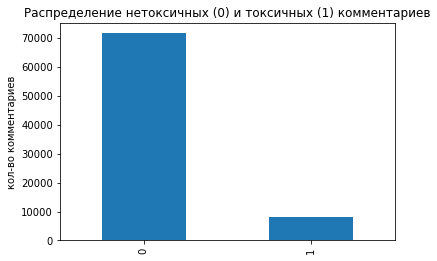

In [8]:
data['toxic'].value_counts().plot(kind='bar')
plt.title("Распределение нетоксичных (0) и токсичных (1) комментариев")
plt.ylabel("кол-во комментариев")
plt.show()

Присутствует **явный дисбаланс классов (классы отличаются примерно в 7 раз)**, который, возможно, будет негативно влиять на качество обучения.

### Создание признаков

**Лемматизация и очистка текста**

In [10]:
# создадим языковой объект spacy
nlp = spacy.load("en_core_web_sm") 

In [11]:
def lemmatize(text): 
    global nlp # cоздаем языковой объект для текущей строки 
    doc = nlp(text) 
    
    return " ".join([token.lemma_ for token in doc]) # получаем список с леммами и склеиваем их в строку 

In [12]:
def clear_text(text):
    clear_text = re.sub(r'[^a-zA-Z]', ' ', text)
    return " ".join(clear_text.split())

In [13]:
batch_size = 14
corpus = pd.Series(dtype='object')
for i in notebook.tqdm(range(data['text'].shape[0] // batch_size)):
        batch = data['text'][batch_size*i:batch_size*(i+1)]
        batch_lemm_text = batch.apply(lemmatize)
        batch_lemm_text = batch_lemm_text.apply(clear_text)
        corpus = pd.concat([corpus, batch_lemm_text]).reset_index(drop=True)

  0%|          | 0/5689 [00:00<?, ?it/s]

In [14]:
# посмотрим как лемматизировался текст
print("Исходный текст:", data['text'][0])
print("Очищенный и лемматизированный текст:", corpus[0])

Исходный текст: "mentioned as of when RED deamed it mentionable. and he buried in the ""have been or are available"" bull line. Gummies are gone, not acceptable to have them in the boxed area w/ OUTDATED not available anymore information. SO yesterday when the soft chewable informat as Tracy said is a few clicks apparent. Red, and please dont' take this personally or as an attack. WHY do you insist on keeping non-current, out of date OLD information out there? Living in yesterday isn't very Wiki, this is hip, new, up to date site, unless of course the article is one someone dead and then there obviously wouldn't be new activity to update.......strange in deed.the all knowing 

"
Очищенный и лемматизированный текст: mention as of when RED deame it mentionable and he bury in the have be or be available bull line gummie be go not acceptable to have they in the boxed area w outdate not available anymore information so yesterday when the soft chewable informat as Tracy say be a few click ap

**Разделение данные на выборки**

In [71]:
text_train, text_test_val, target_train, target_test_val = train_test_split(
    corpus, data['toxic'], test_size=0.4, stratify=data['toxic']) 

In [72]:
text_val, text_test, target_val, target_test = train_test_split(
    text_test_val, target_test_val, test_size=0.5, stratify=target_test_val) 

In [73]:
print(text_train.shape, target_train.shape)
print(text_val.shape, target_val.shape)
print(text_test.shape, target_test.shape)

(47787,) (47787,)
(15929,) (15929,)
(15930,) (15930,)


**Получение матрицы TF-IDF**

In [74]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

[nltk_data] Downloading package stopwords to /Users/olga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [75]:
tf_idf_train = count_tf_idf.fit_transform(text_train.values)
tf_idf_val = count_tf_idf.transform(text_val.values)
tf_idf_test = count_tf_idf.transform(text_test.values)

In [76]:
print(tf_idf_train.shape)
print(tf_idf_val.shape)
print(tf_idf_test.shape)

(47787, 76257)
(15929, 76257)
(15930, 76257)


## Обучение

В процессе обучения будем использовать **Optuna — фреймворк для для автоматизированного поиска оптимальных гиперпараметров для моделей машинного обучения**. Данный инструмент значительно увеличивает скорость перебора гиперпараметров.

Для каждой модели добавлен гиперпараметр "class_weight" для борьбы с дисбалансом.

In [82]:
def objective(trial):
 
    # выберем модели
    classifier_name = trial.suggest_categorical(
        "classifier", ["LogReg", "RandomForest", "SGDClassifier"])
 
    # выберем гиперпараметры:
    if classifier_name == 'LogReg':
        logreg_c = trial.suggest_float("С", 1e-10, 1e10, log=True)
        log_class_weight = trial.suggest_categorical(
            "class_weight", ['balanced', None])
        log_penalty = trial.suggest_categorical(
            'penalty', ['l2', 'none'])
        classifier_obj = LogisticRegression(
            C=logreg_c, class_weight=log_class_weight, penalty=log_penalty, 
            random_state=42, n_jobs=-1)
        
    elif classifier_name == 'SGDClassifier':
        sgd_eta0 = trial.suggest_float("eta0", 0, 1.0)
        sgd_class_weight = trial.suggest_categorical(
            "class_weight", ['balanced', None])
        sgd_loss = trial.suggest_categorical(
            "loss", ['hinge', 'log', 'modified_huber', 'squared_hinge'])
        classifier_obj = SGDClassifier(
            eta0=sgd_eta0, class_weight=sgd_class_weight, loss=sgd_loss, 
            random_state=42, n_jobs=-1)
    else:
        rf_n_estimators = trial.suggest_int("n_estimators", 100, 250, step=50)
        rf_max_depth = trial.suggest_int("max_depth", 2, 15, log=True)
        rf_class_weight = trial.suggest_categorical(
            "class_weight", ['balanced', None])
        classifier_obj = RandomForestClassifier(
            max_depth=rf_max_depth, n_estimators=rf_n_estimators, 
            class_weight=rf_class_weight, random_state=42, n_jobs=-1)
 
    for step in range(100):
        classifier_obj.fit(tf_idf_train, target_train)
 
        # Промежуточное целевое значение
        intermediate_value = f1_score(
            target_val, classifier_obj.predict(tf_idf_val))
        trial.report(intermediate_value, step)
 
        # Обрезка на основании целевого значения
        if trial.should_prune():
            raise optuna.TrialPruned()
        return intermediate_value
 
 
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(
    n_startup_trials=5, n_warmup_steps=30, interval_steps=10))
study.optimize(objective, n_trials=100)

[I 2023-01-29 17:42:06,331] A new study created in memory with name: no-name-d61985be-4d05-49c2-8d0b-3b9b161c0dce
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[I 2023-01-29 17:42:09,659] Trial 0 finished with value: 0.7051597051597053 and parameters: {'classifier': 'LogReg', 'С': 677867.6562530332, 'class_weight': 'balanced', 'penalty': 'none'}. Best is trial 0 with value: 0.7051597051597053.
[I 2023-01-29 17:42:12,310] Trial 1 finished with value: 0.37615057013326003 and parameters: {'classifier': 'RandomForest', 'n_estimators': 200, 'max_depth': 8, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7051597051597053.
[I 2023-01-29 17:42:15,385] Trial 2 finished with value: 0.38273868283739954 and parameters: {'classifier': 'RandomForest', 'n_estimators': 200, 'max_depth': 11, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.705159705159

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[I 2023-01-29 17:42:52,793] Trial 27 finished with value: 0.7308948399738733 and parameters: {'classifier': 'LogReg', 'С': 1.4423570498891912e-10, 'class_weight': None, 'penalty': 'none'}. Best is trial 9 with value: 0.7414084507042255.
[I 2023-01-29 17:42:53,727] Trial 28 finished with value: 0.3280811041895688 and parameters: {'classifier': 'RandomForest', 'n_estimators': 100, 'max_depth': 2, 'class_weight': 'balanced'}. Best is trial 9 with value: 0.7414084507042255.
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
[I 2023-01-29 17:42:54,195] Trial 29 finished with value: 0.699447804364975 and parameters: {'classifier'

[I 2023-01-29 17:44:01,145] Trial 54 finished with value: 0.7348307073416024 and parameters: {'classifier': 'LogReg', 'С': 1092.9864866572282, 'class_weight': None, 'penalty': 'l2'}. Best is trial 48 with value: 0.7561059511523908.
[I 2023-01-29 17:44:04,610] Trial 55 finished with value: 0.7292707292707293 and parameters: {'classifier': 'LogReg', 'С': 5780.630836686447, 'class_weight': None, 'penalty': 'l2'}. Best is trial 48 with value: 0.7561059511523908.
[I 2023-01-29 17:44:06,774] Trial 56 finished with value: 0.5903614457831325 and parameters: {'classifier': 'LogReg', 'С': 0.4139192232563392, 'class_weight': None, 'penalty': 'l2'}. Best is trial 48 with value: 0.7561059511523908.
[I 2023-01-29 17:44:10,209] Trial 57 finished with value: 0.7286615742278313 and parameters: {'classifier': 'LogReg', 'С': 4876.012727525691, 'class_weight': None, 'penalty': 'l2'}. Best is trial 48 with value: 0.7561059511523908.
[I 2023-01-29 17:44:13,102] Trial 58 finished with value: 0.68698060941828

[I 2023-01-29 17:45:42,512] Trial 87 finished with value: 0.7188096146508965 and parameters: {'classifier': 'LogReg', 'С': 2.005887234171565, 'class_weight': None, 'penalty': 'l2'}. Best is trial 68 with value: 0.7578427916813536.
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[I 2023-01-29 17:45:46,262] Trial 88 finished with value: 0.7308948399738733 and parameters: {'classifier': 'LogReg', 'С': 21.004473891398526, 'class_weight': None, 'penalty': 'none'}. Best is trial 68 with value: 0.7578427916813536.
[I 2023-01-29 17:45:49,838] Trial 89 finished with value: 0.5209854014598541 and parameters: {'classifier': 'LogReg', 'С': 0.25032843176417285, 'class_weight': None, 'penalty': 'l2'}. Best is trial 68 with value: 0.7578427916813536.
[I 2023-01-29 17:45:54,484] Trial 90 finished with value: 0.7584033613445377 and parameters: {'classifier': 'LogReg', 'С': 2

In [83]:
print(f"Лучший результат F1: \n{study.best_value}")
print(f"Лучшие параметры : \n{study.best_params}")

Лучший результат F1: 
0.7597061909758658
Лучшие параметры : 
{'classifier': 'LogReg', 'С': 28.87440156593086, 'class_weight': None, 'penalty': 'l2'}


Таким образом, по результатам подбора параметров, лучше всего с данной задачений справляется логистическая регрессия. **Ее результат на валидации – 0.76**

## Тестирование модели

In [84]:
model = LogisticRegression(C=28.87440156593086, class_weight=None, penalty='l2', random_state=42, n_jobs=-1)
model.fit(tf_idf_train, target_train)
predictions = model.predict(tf_idf_test)
print(f'F1-score на тестовой выборке:{f1_score(predictions, target_test)}')

F1-score на тестовой выборке:0.763448275862069


**На тестовой выборке результат у лучшей модели – 0.76**

## Общие выводы по проекту

**В проекте велась работа с текстами комментариев о товарах в интернет магазине**:
   - text – тексты комментариев;
   - toxic – целевой признак.

**Задача состояла в подборе наилучшей по значению f1-score модели для определения токсичных комментариев**.

**Перед началом анализа данные были подготовлены:**
   - каждый текст лемматизирован и очищен от любых знаков, кроме букв;
   - получина матрица TF-IDF для каждого текста.
   
В процессе обучения использовался **инструмент Optuna** — фреймворк для для автоматизированного поиска оптимальных гиперпараметров для моделей машинного обучения. Он значительно увеличивает скорость перебора гиперпараметров.

Для каждой модели добавлен гиперпараметр "class_weight" для борьбы с дисбалансом.

По результатам подбора гиперпараметров **лучший результат показала логистическая регресия**. 

Ее параметры следующие: С = 28.87440156593086, class_weight = None, penalty = l2.

**На валидации лучшая модель показала результат 0.76, а на тесте – 0.76.**